In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

prices = pd.read_excel('data/generated_average_prices.xlsx')
precipitations = pd.read_excel('data/weather_merignac.xlsx', sheet_name='precipitations_mm', index_col=0)
temp_maximals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_maximals', index_col=0)
temp_minimals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_minimals', index_col=0)
frost_days = pd.read_excel('data/weather_merignac.xlsx', sheet_name='frost_days_count', index_col=0)


According to 'The Demand for Expert Opinion: Bordeaux Wine', some important factors are:
- Age of Wine
- Average temperature in the summer (Apr-Sep)
- Harvest rain (Aug-Sep)
- Winter rain (Oct-Mar)

We are going to try and recreate the results of the regression that was run in the paper.

# Feature engineering - recreating the experiment

In [17]:
oldest_vintage=1951
newest_vintage=1980
print(prices.head())
y = prices[['Vintage']]
y['Log Price'] = np.log(prices['Price'])
y = y.set_index('Vintage')

X = pd.DataFrame(index = precipitations.index)
X['Harvest Rain'] = precipitations['Aou'] + precipitations['Sep']

X['Winter Rain'] = precipitations.shift(1)['Oct'] + precipitations.shift(1)['Nov']\
+ precipitations.shift(1)['Dec'] + precipitations['Jan']+ precipitations['Fev'] + precipitations['Mar']

X['Summer Temperature'] = (temp_maximals['Avr'] + temp_maximals['Mai'] + temp_maximals['Jui'] + temp_maximals['Juil']\
+ temp_maximals['Aou'] + temp_maximals['Sep'] + temp_minimals['Avr'] + temp_minimals['Mai'] + temp_minimals['Jui'] + temp_minimals['Juil']\
+ temp_minimals['Aou'] + temp_minimals['Sep']) / 12

   Vintage       Price
0     1950  426.833333
1     1951  645.111111
2     1952  214.235294
3     1953  606.777778
4     1954  685.636364


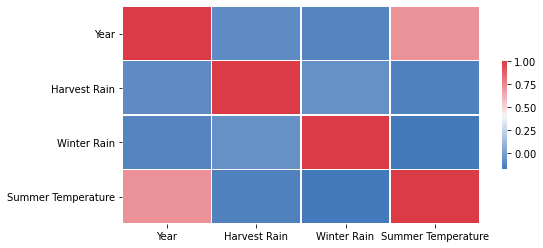

In [18]:
corr = X.reset_index().corr()

plt.figure(figsize=(8,4))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap, linewidth=.5, cbar_kws={"shrink": .5})
plt.show()

# Building the model

In [19]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(normalize=False)

y = y.loc[oldest_vintage:newest_vintage+1,:].reset_index(drop=True)
X = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
model.fit(X, y)
print(X.columns)
for i in range(len(X.columns.to_list())):  
    print(X.columns.to_list()[i], model.coef_[0][i])
print('Total: ',model.score(X,y))

Index(['Year', 'Harvest Rain', 'Winter Rain', 'Summer Temperature'], dtype='object')
Year -0.04057600655573898
Harvest Rain -0.0012304605051568125
Winter Rain 0.0005766372438906674
Summer Temperature 0.09591214074485886
Total:  0.5534611002340954


In [20]:
# Comparing weather against ratings for price prediction


# Adding new variables

In [40]:
y = prices[['Vintage']]
y['Log Price'] = np.log(prices['Price'])
y = y.set_index('Vintage')

X = pd.DataFrame(index = precipitations.index)
X['Harvest Rain'] = precipitations['Aou'] + precipitations['Sep']
X['Summer Rain'] = precipitations['Avr']+precipitations['Mai']+precipitations['Jui']+precipitations['Juil']
X['Winter Rain'] = precipitations.shift(1)['Oct'] + precipitations.shift(1)['Nov']\
+ precipitations.shift(1)['Dec'] + precipitations['Jan']+ precipitations['Fev'] + precipitations['Mar']

X['Summer Temperature'] = (temp_maximals['Avr'] + temp_maximals['Mai'] + temp_maximals['Jui'] + temp_maximals['Juil']\
+ temp_maximals['Aou'] + temp_maximals['Sep'] + temp_minimals['Avr'] + temp_minimals['Mai'] + temp_minimals['Jui'] + temp_minimals['Juil']\
+ temp_minimals['Aou'] + temp_minimals['Sep']) / 12

X['Squared Summer Temperature'] = X['Summer Temperature']**2

X['Temp early'] = (temp_maximals['Jan'] + temp_minimals['Jan']+temp_maximals['Fev'] + temp_minimals['Fev']+temp_maximals['Mar'] + temp_minimals['Mar'])/6

X['Temp late summer'] = (temp_maximals['Aou'] + temp_minimals['Aou']+temp_maximals['Sep'] + temp_minimals['Sep'])/4


X['Frost Days Winter'] = (frost_days.shift(1)['Nov']+frost_days.shift(1)['Dec'] + frost_days['Jan'])/4 \
+(frost_days['Fev']+frost_days['Mar'])/2\
+(frost_days['Avr']+ frost_days['Mai'] + frost_days['Jui'] + frost_days['Juil'])

In [44]:
model = LinearRegression(normalize=False)

oldest_vintage=1981
newest_vintage=2010

y_ex = y.loc[oldest_vintage:newest_vintage+1,:].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
model.fit(X_ex,y_ex)

print(len(y_ex),len(X_ex))
for i in range(len(X_ex.columns.to_list())):  
    print(X_ex.columns.to_list()[i], model.coef_[0][i])
print('Total: ',model.score(X_ex,y_ex))

ValueError: Found input variables with inconsistent numbers of samples: [30, 31]

## Showing feature evolution through time

,Harvest Rain,Summer Rain,Winter Rain,Summer Temperature,Squared Summer Temperature,Temp early,Temp Apr,Temp May,Temp Jun,Temp Jul,Temp late summer,Frost Days Winter,Frost Days Spring,Frost Days Later
Year,,,,,,,,,,,,,,
1950,135.3,181.3,NaN,17.358333,301.311736,7.566667,10.30,15.75,20.70,21.45,17.975,NaN,10,1
1951,177.0,294.3,746.0,16.241667,263.791736,7.200000,11.10,13.00,17.30,20.05,18.000,23.0,13,1
1952,165.5,155.9,566.4,17.300000,299.290000,7.016667,12.75,16.45,19.65,19.85,17.550,29.0,16,3
1953,75.6,224.3,653.3,16.958333,287.585069,5.450000,12.20,16.70,16.35,18.30,19.100,35.0,19,1
1954,171.1,148.0,413.6,15.500000,240.250000,6.433333,10.40,13.90,16.55,16.95,17.600,22.0,10,2


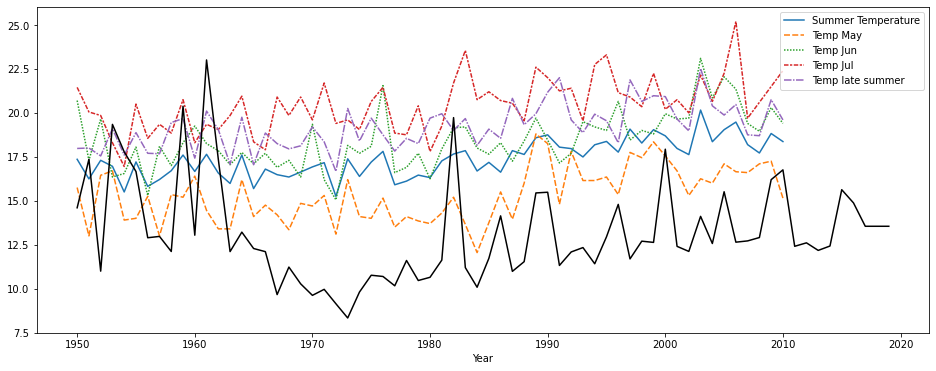

In [86]:
display(X.head())
plt.figure(figsize=(16,6))
sns.lineplot(data=X[['Summer Temperature', 'Temp May', 'Temp Jun', 'Temp Jul', 'Temp late summer']])
plt.plot(y*7 - 30,color='black')
plt.show()

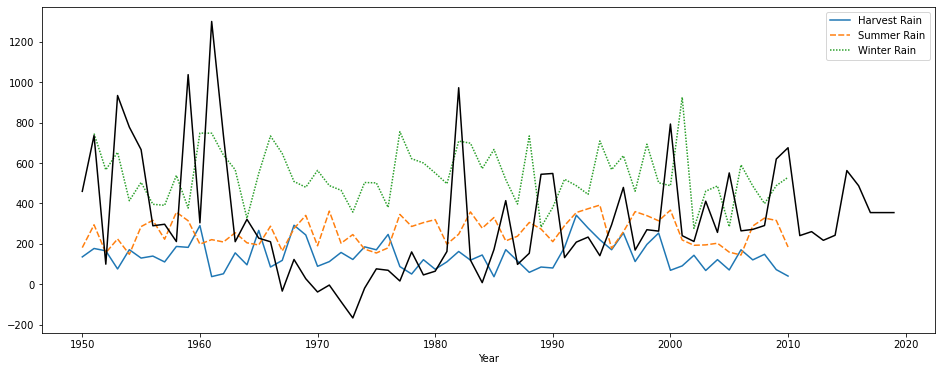

In [75]:
plt.figure(figsize=(16,6))
sns.lineplot(data=X[['Harvest Rain','Summer Rain','Winter Rain']])
plt.plot(y*700 - 4000,color='black')
plt.show()

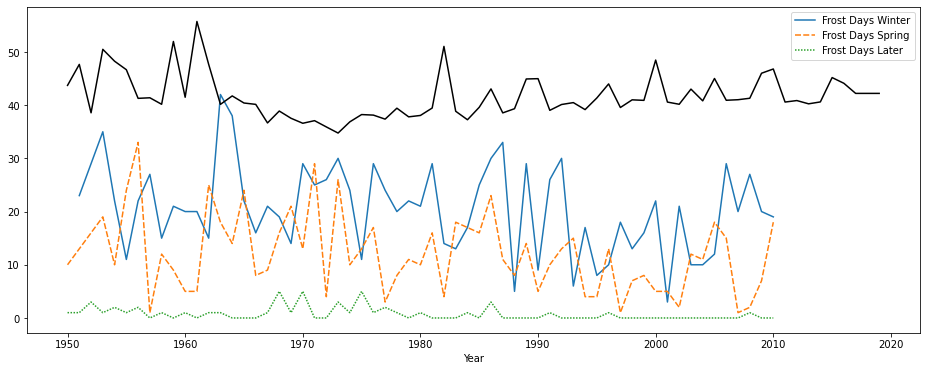

In [82]:
plt.figure(figsize=(16,6))
sns.lineplot(data=X[['Frost Days Winter','Frost Days Spring','Frost Days Later']])
plt.plot(y*10-20,color='black')
plt.show()

While hoping to see squared relations out of these graphs, nothing obvious appears here, except that the frequent late frosts of the 70s were probably accountable for the low quality of wines at that time.

# Trying PCA

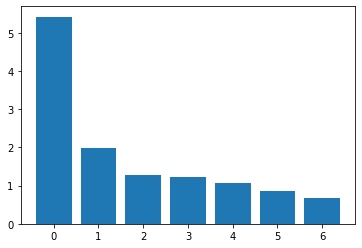

[[-0.05945351  0.03229585 -0.05110878  0.42185348  0.42175557  0.24206631
   0.25759576  0.31141935  0.3313998   0.29290598  0.34140553 -0.17037036
  -0.16962406 -0.21227927]
 [-0.02035636 -0.22806075 -0.43218876  0.14135852  0.1434757  -0.48182806
  -0.04815279  0.10531867  0.11071991  0.22067636  0.11044194  0.37636059
   0.48665599  0.15170552]
 [-0.61346905  0.28591645  0.13356578  0.00181158  0.00171077 -0.28256009
   0.32118501 -0.17221658 -0.25973761 -0.05609055  0.13957218  0.12426925
   0.10923627 -0.44038317]
 [ 0.49284635  0.73760545 -0.07009272  0.01592765  0.01060272 -0.07886507
  -0.10641819  0.23924774 -0.2462799   0.12213253  0.02929602  0.03158337
   0.17476354 -0.15814351]
 [ 0.08583376  0.0089079   0.52460784  0.04865181  0.04551249 -0.21690692
   0.07103774 -0.23139276  0.18400079  0.28581037 -0.06294469 -0.49604649
   0.4714862   0.13927176]
 [-0.39825038  0.20819289  0.15473134  0.06035671  0.05684409  0.05423204
  -0.52392089  0.17330413 -0.11918479 -0.10123681  

In [97]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA(n_components=7)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)



pipeline.fit(X.dropna(axis=0))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.show()
print(pca.components_)

X = X.dropna(axis=0)
X2 = pd.DataFrame(pca.transform(X), index=X.index)

In [101]:
model = LinearRegression(normalize=False)

oldest_vintage=1951
newest_vintage=1980

X2 = X2.loc[oldest_vintage:newest_vintage]
y_ex = y.loc[X2.index,:].reset_index(drop=True)
X_ex = X2.reset_index()
model.fit(X_ex,y_ex)

print(len(y_ex),len(X_ex))
for i in range(len(X_ex.columns.to_list())):  
    print(X_ex.columns.to_list()[i], model.coef_[0][i])
print('Total: ',model.score(X_ex,y_ex))

16 16
Year 0.010746483541955312
0 0.0017413039893693911
1 -0.0009178329622593768
2 0.01063274501198518
3 -0.0015018222688261982
4 0.013853701148092229
5 -0.01890367720634304
6 -0.009556462363135686
Total:  0.5924196526112075
